In [21]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

C:\Users\dziew\AppData\Local\Temp\ipykernel_1432\159884441.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [22]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


## Przygotowanie danych

In [23]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

# Budowanie autoenkodera wariacyjnego 
VAE tak samo jak zwykły autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z**, oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Zacznijmy od stworzenia enkodera

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [25]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat
        

### Uzupełnij metodę losowania nowych przykładów w przestrzeni ukrytej

In [26]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        # Change to proper sampling
        eps = torch.randn(mean)
        z = mean + var * eps
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [27]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

# Możemy zacząć trening

In [28]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [29]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

KeyboardInterrupt: 

In [30]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [31]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

TypeError: randn(): argument 'size' (position 1) must be tuple of ints, not Tensor

In [32]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

c:\Users\dziew\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


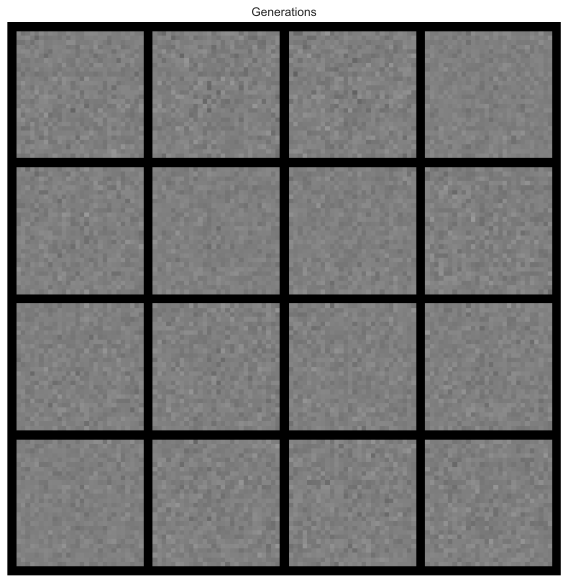

In [33]:
generate_images(vae, 16 , device)

## Co poszło nie tak?

In [34]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=784).to(device)

In [35]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [36]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [37]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

TypeError: randn(): argument 'size' (position 1) must be tuple of ints, not Tensor

In [ ]:
generate_images(vae, 16 , device)

# Przestrzeń ukryta VAE

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [38]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

ModuleNotFoundError: No module named 'umap'

In [ ]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

In [ ]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
vae = VAE(latent_dim=2, hidden_dim=256, x_dim=784).to(device)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
generate_images(vae, 16 , device)

In [ ]:
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = train_img_embeds[1][:5000].cpu()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

# Generative Adversarial Networks

In [39]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [40]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

In [41]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [42]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.0737, discriminator real acc: 0.81


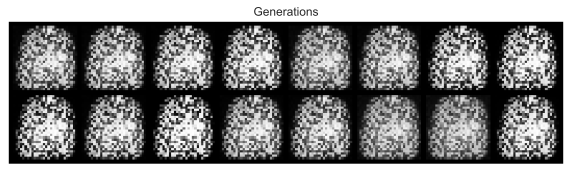

Epoch: 1, discrimiantor fake error: 0.0354, discriminator real acc: 0.934
Epoch: 2, discrimiantor fake error: 0.0244, discriminator real acc: 0.952
Epoch: 3, discrimiantor fake error: 0.00595, discriminator real acc: 0.977
Epoch: 4, discrimiantor fake error: 0.00154, discriminator real acc: 0.991
Epoch: 5, discrimiantor fake error: 0.00198, discriminator real acc: 0.995
Epoch: 6, discrimiantor fake error: 0.0025, discriminator real acc: 0.996
Epoch: 7, discrimiantor fake error: 0.00532, discriminator real acc: 0.995
Epoch: 8, discrimiantor fake error: 0.0149, discriminator real acc: 0.987
Epoch: 9, discrimiantor fake error: 0.019, discriminator real acc: 0.981
Epoch: 10, discrimiantor fake error: 0.0189, discriminator real acc: 0.979


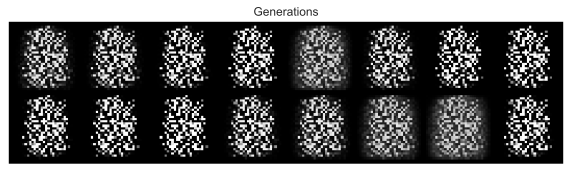

Epoch: 11, discrimiantor fake error: 0.00886, discriminator real acc: 0.987
Epoch: 12, discrimiantor fake error: 0.00607, discriminator real acc: 0.992
Epoch: 13, discrimiantor fake error: 0.0112, discriminator real acc: 0.991
Epoch: 14, discrimiantor fake error: 0.0723, discriminator real acc: 0.955
Epoch: 15, discrimiantor fake error: 0.0547, discriminator real acc: 0.937
Epoch: 16, discrimiantor fake error: 0.0246, discriminator real acc: 0.965
Epoch: 17, discrimiantor fake error: 0.0274, discriminator real acc: 0.972
Epoch: 18, discrimiantor fake error: 0.0646, discriminator real acc: 0.945
Epoch: 19, discrimiantor fake error: 0.0451, discriminator real acc: 0.944
Epoch: 20, discrimiantor fake error: 0.0253, discriminator real acc: 0.971


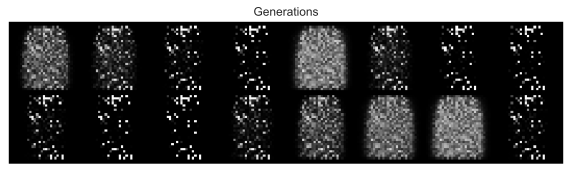

Epoch: 21, discrimiantor fake error: 0.0312, discriminator real acc: 0.966
Epoch: 22, discrimiantor fake error: 0.0514, discriminator real acc: 0.952
Epoch: 23, discrimiantor fake error: 0.0638, discriminator real acc: 0.944
Epoch: 24, discrimiantor fake error: 0.0446, discriminator real acc: 0.949
Epoch: 25, discrimiantor fake error: 0.0322, discriminator real acc: 0.96
Epoch: 26, discrimiantor fake error: 0.0392, discriminator real acc: 0.961
Epoch: 27, discrimiantor fake error: 0.0408, discriminator real acc: 0.957
Epoch: 28, discrimiantor fake error: 0.037, discriminator real acc: 0.964
Epoch: 29, discrimiantor fake error: 0.0413, discriminator real acc: 0.959
Epoch: 30, discrimiantor fake error: 0.0396, discriminator real acc: 0.962


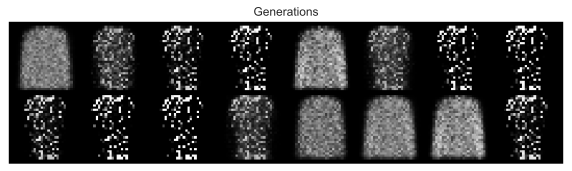

Epoch: 31, discrimiantor fake error: 0.0403, discriminator real acc: 0.957
Epoch: 32, discrimiantor fake error: 0.0449, discriminator real acc: 0.957
Epoch: 33, discrimiantor fake error: 0.0512, discriminator real acc: 0.953
Epoch: 34, discrimiantor fake error: 0.0461, discriminator real acc: 0.956
Epoch: 35, discrimiantor fake error: 0.0507, discriminator real acc: 0.953
Epoch: 36, discrimiantor fake error: 0.0572, discriminator real acc: 0.948
Epoch: 37, discrimiantor fake error: 0.0651, discriminator real acc: 0.939
Epoch: 38, discrimiantor fake error: 0.0758, discriminator real acc: 0.933
Epoch: 39, discrimiantor fake error: 0.0623, discriminator real acc: 0.933
Epoch: 40, discrimiantor fake error: 0.062, discriminator real acc: 0.946


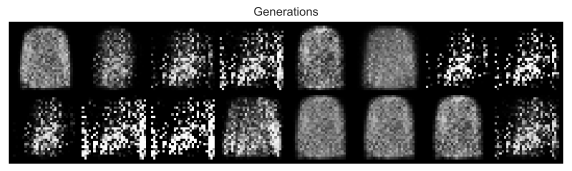

Epoch: 41, discrimiantor fake error: 0.0639, discriminator real acc: 0.938
Epoch: 42, discrimiantor fake error: 0.0618, discriminator real acc: 0.94
Epoch: 43, discrimiantor fake error: 0.0599, discriminator real acc: 0.945
Epoch: 44, discrimiantor fake error: 0.0666, discriminator real acc: 0.939
Epoch: 45, discrimiantor fake error: 0.0642, discriminator real acc: 0.937
Epoch: 46, discrimiantor fake error: 0.0717, discriminator real acc: 0.931
Epoch: 47, discrimiantor fake error: 0.063, discriminator real acc: 0.94
Epoch: 48, discrimiantor fake error: 0.0611, discriminator real acc: 0.934
Epoch: 49, discrimiantor fake error: 0.0673, discriminator real acc: 0.937
Epoch: 50, discrimiantor fake error: 0.0662, discriminator real acc: 0.932


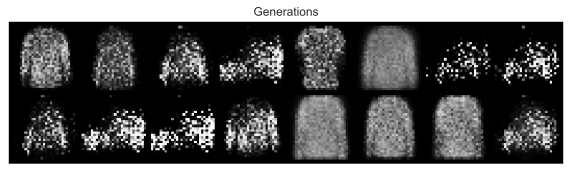

Epoch: 51, discrimiantor fake error: 0.0589, discriminator real acc: 0.942
Epoch: 52, discrimiantor fake error: 0.0686, discriminator real acc: 0.934
Epoch: 53, discrimiantor fake error: 0.068, discriminator real acc: 0.929
Epoch: 54, discrimiantor fake error: 0.0707, discriminator real acc: 0.929
Epoch: 55, discrimiantor fake error: 0.0722, discriminator real acc: 0.931
Epoch: 56, discrimiantor fake error: 0.0682, discriminator real acc: 0.93
Epoch: 57, discrimiantor fake error: 0.0639, discriminator real acc: 0.935
Epoch: 58, discrimiantor fake error: 0.0681, discriminator real acc: 0.935
Epoch: 59, discrimiantor fake error: 0.0698, discriminator real acc: 0.928
Epoch: 60, discrimiantor fake error: 0.0632, discriminator real acc: 0.935


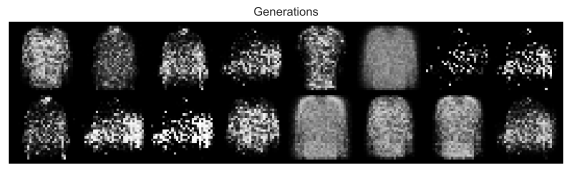

Epoch: 61, discrimiantor fake error: 0.0711, discriminator real acc: 0.934
Epoch: 62, discrimiantor fake error: 0.0753, discriminator real acc: 0.925
Epoch: 63, discrimiantor fake error: 0.0796, discriminator real acc: 0.924
Epoch: 64, discrimiantor fake error: 0.086, discriminator real acc: 0.919
Epoch: 65, discrimiantor fake error: 0.0885, discriminator real acc: 0.911
Epoch: 66, discrimiantor fake error: 0.0929, discriminator real acc: 0.912
Epoch: 67, discrimiantor fake error: 0.0805, discriminator real acc: 0.918
Epoch: 68, discrimiantor fake error: 0.0789, discriminator real acc: 0.92
Epoch: 69, discrimiantor fake error: 0.0808, discriminator real acc: 0.925
Epoch: 70, discrimiantor fake error: 0.0867, discriminator real acc: 0.913


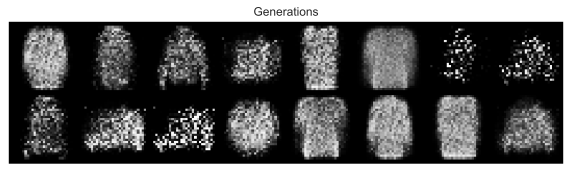

Epoch: 71, discrimiantor fake error: 0.0878, discriminator real acc: 0.912
Epoch: 72, discrimiantor fake error: 0.0939, discriminator real acc: 0.914
Epoch: 73, discrimiantor fake error: 0.0981, discriminator real acc: 0.908
Epoch: 74, discrimiantor fake error: 0.0936, discriminator real acc: 0.896
Epoch: 75, discrimiantor fake error: 0.0924, discriminator real acc: 0.912
Epoch: 76, discrimiantor fake error: 0.0959, discriminator real acc: 0.915
Epoch: 77, discrimiantor fake error: 0.0974, discriminator real acc: 0.903
Epoch: 78, discrimiantor fake error: 0.0999, discriminator real acc: 0.903
Epoch: 79, discrimiantor fake error: 0.108, discriminator real acc: 0.898
Epoch: 80, discrimiantor fake error: 0.112, discriminator real acc: 0.894


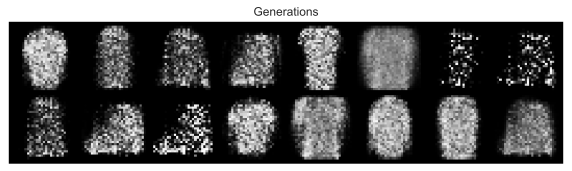

Epoch: 81, discrimiantor fake error: 0.104, discriminator real acc: 0.896
Epoch: 82, discrimiantor fake error: 0.0933, discriminator real acc: 0.907
Epoch: 83, discrimiantor fake error: 0.0999, discriminator real acc: 0.906
Epoch: 84, discrimiantor fake error: 0.109, discriminator real acc: 0.898
Epoch: 85, discrimiantor fake error: 0.101, discriminator real acc: 0.903
Epoch: 86, discrimiantor fake error: 0.104, discriminator real acc: 0.896
Epoch: 87, discrimiantor fake error: 0.105, discriminator real acc: 0.9
Epoch: 88, discrimiantor fake error: 0.111, discriminator real acc: 0.893
Epoch: 89, discrimiantor fake error: 0.11, discriminator real acc: 0.894
Epoch: 90, discrimiantor fake error: 0.1, discriminator real acc: 0.899


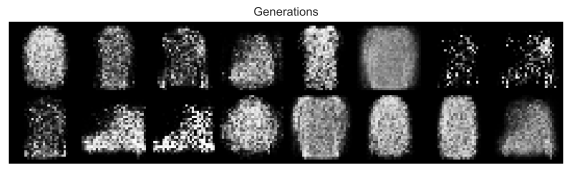

Epoch: 91, discrimiantor fake error: 0.109, discriminator real acc: 0.891
Epoch: 92, discrimiantor fake error: 0.115, discriminator real acc: 0.893
Epoch: 93, discrimiantor fake error: 0.119, discriminator real acc: 0.885
Epoch: 94, discrimiantor fake error: 0.119, discriminator real acc: 0.88
Epoch: 95, discrimiantor fake error: 0.133, discriminator real acc: 0.871
Epoch: 96, discrimiantor fake error: 0.139, discriminator real acc: 0.862
Epoch: 97, discrimiantor fake error: 0.134, discriminator real acc: 0.866
Epoch: 98, discrimiantor fake error: 0.13, discriminator real acc: 0.874
Epoch: 99, discrimiantor fake error: 0.127, discriminator real acc: 0.871


In [43]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

## Stwórzmy model warunkowany klasą
Może się przydać F.one_hot

In [44]:
from torch.nn.functional import one_hot

In [45]:
one_hot(torch.tensor([4,3,4]),10)

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

# Ewaluacja modeli generatywnych

In [46]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [47]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [48]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [49]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(test_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  87.28 % of the dataset


In [50]:
vae = vae_32

NameError: name 'vae_32' is not defined

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
#     generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    generations_gan = generator(fixed_noise)
    generations_vae = vae.decoder(fixed_noise)

In [ ]:
orig_data = [x[0] for x in list(test_set)[:1000]]
orig_data = torch.cat(orig_data)

In [ ]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()
#     dist_cond_gan = evaluator.get_features(generations_cond_gan.to(device)).cpu()

In [ ]:
for idx in range(5):
    bins = 10
    w = 0.3
    plt.figure(figsize=(10,10))
    plt.hist([dist_orig_data[:,idx].numpy(),dist_vae[:,idx].numpy(),dist_gan[:,idx]], bins, alpha=0.5, label=['orig','vae','gan','cond_gan'],width=w)
    plt.legend(loc='upper right')
    plt.show();
    plt.close()

In [ ]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
orig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [ ]:
for name, obj in zip(['orig','vae','gan','cond_gan'],[dist_orig_data_2.numpy(),dist_vae.numpy(),dist_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")